# Flights Price Analysis 

The goal of this notebook is to perform some analyses on a dataset containing one-way flights found on Expedia from 2022-04-16 to 2022-10-05  (you can find it at this [link](https://www.kaggle.com/datasets/dilwong/flightprices)).

In [1]:
%%configure -f
{"executorMemory":"8G", "numExecutors":2, "executorCores":3, "conf": {"spark.dynamicAllocation.enabled": "false"}}

In [2]:
val bucketname = "unibo-bd2223-vfolin"

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1678994245204_0001,spark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

bucketname: String = unibo-bd2223-vfolin


In [3]:
/* Required imports */

import org.apache.spark.storage.StorageLevel
import spark.implicits._
import java.time.temporal.ChronoUnit.DAYS
import java.time.LocalDate
import org.apache.spark.sql.SaveMode
import org.apache.spark.mllib.stat.Statistics
import org.apache.spark.mllib.linalg._
import java.util.concurrent.TimeUnit

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.storage.StorageLevel
import spark.implicits._
import java.time.temporal.ChronoUnit.DAYS
import java.time.LocalDate
import org.apache.spark.sql.SaveMode
import org.apache.spark.mllib.stat.Statistics
import org.apache.spark.mllib.linalg._
import java.util.concurrent.TimeUnit


## Data Preparation

We consider the following columns:
- flightID: Flight identifier.
- searchDate: Date the record was obtained from Expedia.
- searchMonth: Month the record was obtained from Expedia.
- searchDay: Day the record was obtained from Expedia.
- flightDate: The date of the flight.
- flightMonth: The month of the flight.
- flightDay: The day of the flight.
- startingAirport: 3-letter code for the departure airport.
- destinationAirport: 3-letter code for the destination airport.
- duration: Travel duration in minutes.
- isEconomy: Is basic economy?
- isRefundable: Is the ticket refundable?
- isNonStop: Is the flight non-stop?
- baseFare: Price of the ticket (not including taxes).
- totalFare: Price of the ticket, including taxes and fees.
- seatsRemaining: Number of remaining seats.
- travelDistance: The total travel distance in miles.

In [4]:
case class FlightData(
    flightID:String,
    searchDate:String,
    searchMonth:String,
    searchDay:String,
    flightDate:String,
    flightMonth:String,
    flightDay:String,
    startingAirport:String,
    destinationAirport:String,
    duration:Int,
    isEconomy:Boolean,
    isRefundable:Boolean,
    isNonStop:Boolean,
    baseFare:Double,
    totalFare:Double,
    seatsRemaining:Int,
    travelDistance:Int
)

object FlightData {

    def parse(line:String) = {
        val input = line.split(",")
        val flightID = input(0)
        val searchDate = input(1)
        val searchMonth = searchDate.substring(5,7)
        val searchDay = searchDate.substring(8,10)
        val flightDate = input(2)
        val flightMonth = flightDate.substring(5,7)
        val flightDay = flightDate.substring(8,10)
        val startingAirport = input(3)
        val destinationAirport = input(4)
        val dur = input(6).replace("P","").replace("T","").split("D|H|M").map(x => x.toInt)
        val duration = dur.length match {
            case 3 => dur(0) * 1440 + dur(1) * 60 + dur(2)
            case 2 => dur(0) * 60 + dur(1)
            case 1 => dur(0)
        }
        val isEconomy = input(8).toBoolean
        val isRefundable = input(9).toBoolean
        val isNonStop = input(10).toBoolean
        val baseFare = input(11).toDouble
        val totalFare = input(12).toDouble
        val seatsRemaining = input(13).toInt
        val travelDistance = input(14) match {
            case "" => 0
            case _ => input(14).toInt
        }
        
        new FlightData(flightID,searchDate,searchMonth,searchDay,flightDate,flightMonth,flightDay,startingAirport,
                       destinationAirport,duration,isEconomy,isRefundable,isNonStop,baseFare,totalFare,
                       seatsRemaining,travelDistance)
    }
}

// Create an RRD from the CSV file.
val rdd = sc.textFile("s3a://"+bucketname+"/datasets/itineraries.csv")
// Extract header from RDD and parse every row.
val header = rdd.first(); 
val rddFlights = rdd.filter(row => row != header).map(FlightData.parse)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defined class FlightData
defined object FlightData
Companions must be defined together; you may wish to use :paste mode for this.
rdd: org.apache.spark.rdd.RDD[String] = s3a://unibo-bd2223-vfolin/datasets/itineraries.csv MapPartitionsRDD[1] at textFile at <console>:41
header: String = legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
rddFlights: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[3] at map at <console>:41


#### Cache the dataset to explore the data and perform further analyses

If the RDD does not fit in memory, _persist(StorageLevel.MEMORY_AND_DISK)_ stores the partitions that do not fit on disk, and it reads them from there when they are needed.

In [5]:
rddFlights.persist(StorageLevel.MEMORY_AND_DISK)
println("Number of searches performed: " + rddFlights.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res7: rddFlights.type = MapPartitionsRDD[3] at map at <console>:41
Number of searches performed: 82138753


| RDD's name | Number of records | Size | Partitions
| ----- | ----- | ----- | ----- |  
| rddFlights | 82138753 | 10.8 GB |  927

#### Visualize data as a DataFrame

In [ ]:
val columns = Seq("flightID",
                  "searchDate",
                  "searchMonth",
                  "searchDay",
                  "flightDate",
                  "flightMonth",
                  "flightDay",
                  "startingAirport",
                  "destinationAirport",
                  "duration",
                  "isEconomy",
                  "isRefundable",
                  "isNonStop",
                  "baseFare",
                  "totalFare",
                  "seatsRemaining",
                  "travelDistance")

val flightDataframe = rddFlights.toDF(columns:_*)
flightDataframe.show(3,truncate=40,vertical=true)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import spark.implicits._
columns: Seq[String] = List(flightID, searchDate, searchMonth, searchDay, flightDate, flightMonth, flightDay, startingAirport, destinationAirport, duration, isEconomy, isRefundable, isNonStop, baseFare, totalFare, seatsRemaining, travelDistance)
flightDataframe: org.apache.spark.sql.DataFrame = [flightID: string, searchDate: string ... 15 more fields]
-RECORD 0----------------------------------------------
 flightID           | 9ca0e81111c683bec1012473feefd28f 
 searchDate         | 2022-04-16                       
 searchMonth        | 04                               
 searchDay          | 16                               
 flightDate         | 2022-04-17                       
 flightMonth        | 04                               
 flightDay          | 17                               
 startingAirport    | ATL                              
 destinationAirport | BOS                              
 duration           | 149                              
 isEc

#### Define a function to compute the number of days between the searchDate and the flightDate

In [6]:
def daysBetween(x: FlightData): Long = {
        val searchDate = LocalDate.parse(x.searchDate);
        val flightDate = LocalDate.parse(x.flightDate);
        val daysBetween = DAYS.between(searchDate, flightDate);
        daysBetween
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

daysBetween: (x: FlightData)Long


#### Define a function to identify a certain week in the period of interest with a given number

_computeWeek_ is a function that, given a flight, returns the week in which the flight will depart.

The first week for which we have data in our dataset will be referred as week **0**.

In [7]:
def computeWeek(flightDate: String): Long = {
    val firstDate = LocalDate.parse("2022-04-16");
    val actualDate = LocalDate.parse(flightDate);
    DAYS.between(firstDate, actualDate)/7.toInt;
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

computeWeek: (flightDate: String)Long


## Data Exploration

Perform the following queries to explore the dataset:

In [ ]:
val rddDistinctFlights = rddFlights.
    map(x => (x.flightID, x.startingAirport, x.flightMonth, x.isNonStop, x.isEconomy, x.destinationAirport)).
    distinct()

rddDistinctFlights.persist(StorageLevel.MEMORY_AND_DISK)

println("Number of distinct flights: " + rddDistinctFlights.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddDistinctFlights: org.apache.spark.rdd.RDD[(String, String, String, Boolean, Boolean, String)] = MapPartitionsRDD[11] at distinct at <console>:33
res14: rddDistinctFlights.type = MapPartitionsRDD[11] at distinct at <console>:33
Number of distinct flights: 6741921


We save the dataset in memory for further analyses, and we check the memory occupation.

| RDD's name | Number of records | Size |  Partitions 
| ----- | ----- | ----- | ----- |
| rddDistinctFlights | 6741921 | 460.9 MB | 927

In [ ]:
println("Number of distinct startingAirport: " + rddDistinctFlights.map(x => (x._2)).distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of distinct startingAirport: 16


| Query | Count |
| ----- | ----- | 
| Number of distinct startingAirport | 16 |

In [ ]:
println("Number of flights by starting airport")
val flightsByAirport = rddDistinctFlights.
    map(x => (x._2, 1)).
    reduceByKey(_+_).
    collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of flights by starting airport
flightsByAirport: Array[(String, Int)] = Array((LAX,647762), (CLT,439551), (JFK,321474), (BOS,503551), (OAK,322976), (LGA,489480), (ATL,411753), (MIA,386155), (DTW,369802), (PHL,399106), (SFO,568692), (EWR,329291), (ORD,416925), (DEN,359393), (IAD,342082), (DFW,433928))


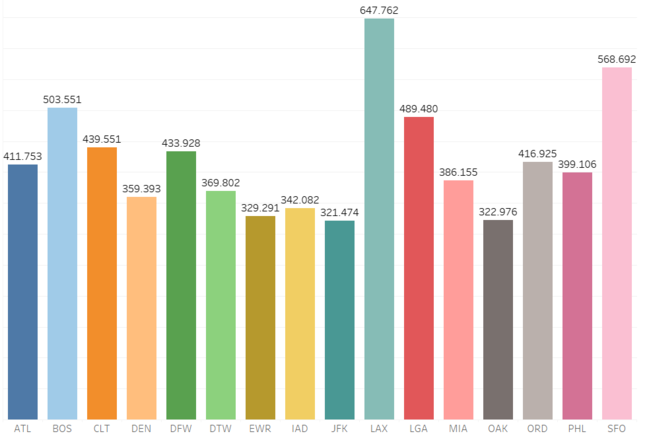

In [ ]:
println("Number of flights by month")
val flightsByMonth = rddDistinctFlights.
    map(x => (x._3, 1)).
    reduceByKey(_+_).
    collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Number of flights by month
flightsByMonth: Array[(String, Int)] = Array((04,205745), (05,768008), (06,1022075), (07,1080180), (08,1203901), (09,1192040), (10,880474), (11,389498))


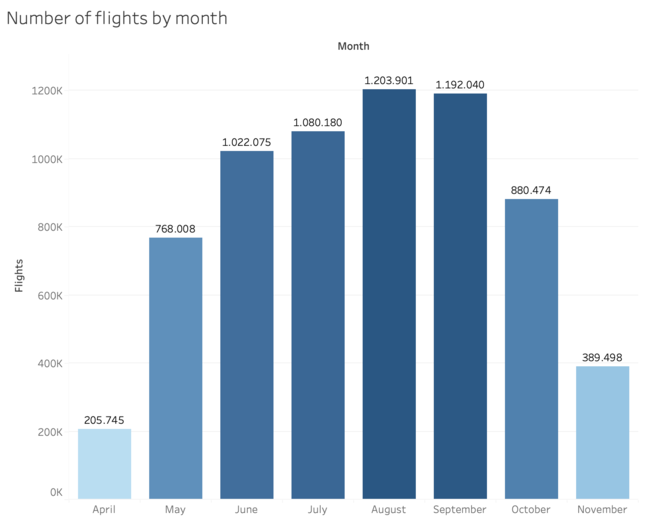

In [ ]:
println("Number of routes: " + rddDistinctFlights.map(x => (x._2, x._6)).distinct().count()) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Number of routes: 235


| Query | Count |
| ----- | ----- | 
| Number of routes  | 235 |

In [ ]:
println("Number of flights that offer an economy fare: " + rddFlights.
        filter(x => x.isEconomy).
        map(x => x.flightID).
        distinct().
        count())

println("Number of flights that offer a non-economy fare: " + rddFlights.
        filter(x => !x.isEconomy).
        map(x => x.flightID).
        distinct().
        count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of flights that offer an economy fare: 1189124
Number of flights that offer a non economy fare: 5551777


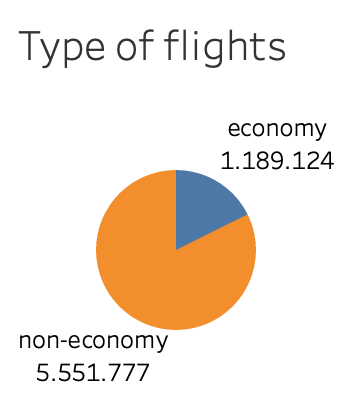

In [ ]:
println("Number of direct flights: " + rddDistinctFlights.filter(x => x._4).count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of direct flights: 809106


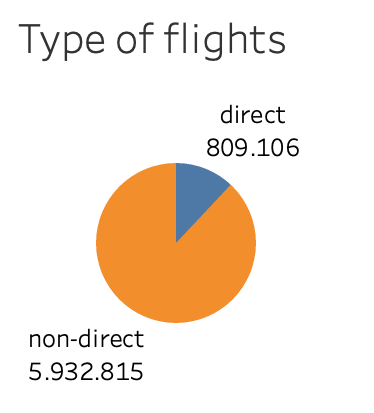

## Jobs

In [8]:
/* We define the output path where our results will be saved */

val output_path = "s3a://"+bucketname+"/spark/bdexam"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

output_path: String = s3a://unibo-bd2223-vfolin/spark/bdexam


### 1 - Veronika Folin

#### Objective

The change in the ticket price occurring 30 days before flight departure is calculated, dividing the result between economy and non-economy tickets. \
The correlation between the change in price and the number of seats remaining on that flight is then displayed.

-------------------------

We filter data to obtain searches made in the last 30 days before the flight departure. \
The filtering operation allows us to reduce the number of records.

We save the dataset in memory to use it as a starting point for other queries. \
Every time we cache something, we check its memory occupation and the number of partitions it is distributed over.

In [9]:
val rddFlightsFiltered = rddFlights.
    filter(x => daysBetween(x) <= 30)

rddFlightsFiltered.persist(StorageLevel.MEMORY_AND_DISK)

"Number of filtered flights: " + rddFlightsFiltered.count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddFlightsFiltered: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[4] at filter at <console>:40
res12: rddFlightsFiltered.type = MapPartitionsRDD[4] at filter at <console>:40
res14: String = Number of filtered flights: 47674280


| RDD's name | Number of records | Size | Partitions 
| ----- | ----- | ----- | ----- | 
| rddFlightsFiltered | 47674280 | 6.3 GB | 927

We divide the previous result between economy and non-economy tickets.

In [10]:
val rddEconomyFlights = rddFlightsFiltered.filter(_.isEconomy)

rddEconomyFlights.persist(StorageLevel.MEMORY_AND_DISK)

"Number of economy flights: " + rddEconomyFlights.count()


val rddNoEconomyFlights = rddFlightsFiltered.filter(!_.isEconomy)

rddNoEconomyFlights.persist(StorageLevel.MEMORY_AND_DISK)

"Number of non-economy flights: " + rddNoEconomyFlights.count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddEconomyFlights: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[5] at filter at <console>:37
res16: rddEconomyFlights.type = MapPartitionsRDD[5] at filter at <console>:37
res18: String = Number of economy flights: 6356288
rddNoEconomyFlights: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[6] at filter at <console>:39
res22: rddNoEconomyFlights.type = MapPartitionsRDD[6] at filter at <console>:39
res24: String = Number of non-economy flights: 41317992


| RDD's name | Number of records | Size | Partitions 
| ----- | ----- | ----- | ----- | 
| rddEconomyFlights | 6356288 | 865.3 MB | 927
| rddNoEconomyFlights | 41317992 | 5.4 GB | 927

#### Not optimized version

An early version of the query is provided below.

First of all, we calculate the average ticket price in a given number of days before departure of economy flights. \
Then, we map _rddEconomyFlights_ to a pair of key/value, where the key is the number of days to flight departure and the value is the _baseFare_. \
Afterward, we compute the average price defining an accumulator as a tuple of double: the first value is the sum of the prices in a given number of days before departure and the second value is the number of occurrencies. \
After the aggregation, we perform a map to divide the totalPrice by the numberOfInstances to yield the average price.

We conduct similar calculations on the _seatsRemaining_ value to obtain the average number of seats remaining on flights over a given number of days before departure.

We join average ticket prices with the average number of remaining seats. \
Then, we save the result on S3 to reuse it and view a graph of the results obtained.

Finally, we calculate the correlation matrix between the attributes AverageSeatsRemaining and AveragePrice to assess the relationship between these two attributes.

In [11]:
/* ECONOMY FLIGHTS */

val t0 = System.nanoTime()

val rddAveragePriceEconomy = rddEconomyFlights.
    map(x => (daysBetween(x), x.baseFare)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddAverageSeatsRemainingEconomy = rddEconomyFlights.
    map(x => (daysBetween(x), x.seatsRemaining)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddEconomyResult = rddAverageSeatsRemainingEconomy.join(rddAveragePriceEconomy).
    map({case(k,v) => (k, v._1, v._2)})

rddEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val economyData = rddEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
    Vectors.dense(averageSeatsRemaining, averagePrice)})
val correlMatrixEconomy: Matrix = Statistics.corr(economyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 1874626710206
rddAveragePriceEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[9] at map at <console>:45
rddAverageSeatsRemainingEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[12] at map at <console>:45
rddEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[16] at map at <console>:41
economyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[22] at map at <console>:38
correlMatrixEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.9055847376663385
-0.9055847376663385  1.0
t1: Long = 1927010999404
Elapsed time: 52.385336883783964 seconds


The following table reports a summary of the execution of the previous query.

| Version | Input data | Input size | Time in seconds
| ----- | ----- | ----- | ----- | 
| Not optimized | EconomyFlights | 865.3 MB | 52.385336883783964

We then display a graph showing the trend of the average price (vertical blue bars) and the average remaining seats (labels) over the last 30 days before economy flights.

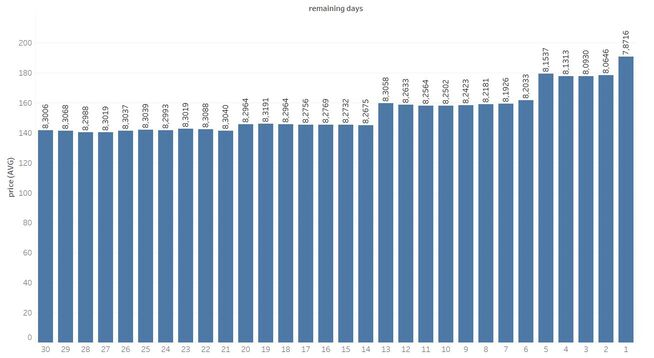

Now, we perform the same query on the non-economy flights' data.

In [12]:
/* NON-ECONOMY FLIGHTS*/

val t0 = System.nanoTime()

val rddAveragePriceNoEconomy = rddNoEconomyFlights.
    map(x => (daysBetween(x), x.baseFare)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddAverageSeatsRemainingNoEconomy = rddNoEconomyFlights.
    map(x => (daysBetween(x), x.seatsRemaining)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddNoEconomyResult = rddAverageSeatsRemainingNoEconomy.join(rddAveragePriceNoEconomy).
    map({case(k,v) => (k, v._1, v._2)})

rddNoEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val noEconomyData = rddNoEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
    Vectors.dense(averageSeatsRemaining, averagePrice)})
val correlMatrixNoEconomy: Matrix = Statistics.corr(noEconomyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 1928112722185
rddAveragePriceNoEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[33] at map at <console>:45
rddAverageSeatsRemainingNoEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[36] at map at <console>:45
rddNoEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[40] at map at <console>:41
noEconomyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[46] at map at <console>:38
correlMatrixNoEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.7933229293345507
-0.7933229293345507  1.0
t1: Long = 2037063052706
Elapsed time: 108.95250952761042 seconds


We display the same table and graph as before with respect to non-economy flights.

| Version | Input data | Input size | Time in seconds
| ----- | ----- | ----- | ----- | 
| Not optimized | NoEconomyFlights | 5.4 GB |  108.95250952761042

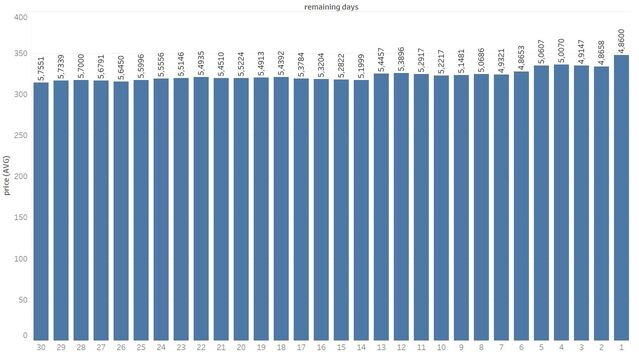

#### Optimized version

To optimize the query and reduce execution times, we decided to avoid the creation of two separate datasets and the subsequent join operation.

Therefore, we calculate the average ticket price and the average remaining seats in the same _aggregateByKey_ operation, using an accumulator composed of an integer value representing the number of occurrences and a tuple of doubles representing the sum of the remaining seats and the sum of prices. \
The next map will take care of calculating the two averages in one shot.

In [13]:
/* ECONOMY FLIGHT */

val t0 = System.nanoTime()

val zeroValue = (0, (0.0, 0.0))

val rddEconomyResult = rddEconomyFlights.
    map(x => (daysBetween(x), (x.seatsRemaining, x.baseFare))).
    aggregateByKey(zeroValue)(
            (tuple, prev) => {
                val count = tuple._1 + 1
                val seatsRemainingSum = tuple._2._1 + prev._1
                val baseFareSum = tuple._2._2 + prev._2
                (count, (seatsRemainingSum, baseFareSum))
            },
            (tuple1, tuple2) => {
                val count1 = tuple1._1 + tuple2._1
                val seatsRemainingSum1 = tuple1._2._1 + tuple2._2._1
                val baseFareSum1 = tuple1._2._2 + tuple2._2._2
                (count1, (seatsRemainingSum1, baseFareSum1))
            }
        ).
    map({case(k,(count2, (seatsRemainingSum2, baseFareSum2))) => (k, seatsRemainingSum2/count2, baseFareSum2/count2)})

rddEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val economyData = rddEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
     Vectors.dense(averageSeatsRemaining, averagePrice)})

val correlMatrixEconomy: Matrix = Statistics.corr(economyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 2037767652907
zeroValue: (Int, (Double, Double)) = (0,(0.0,0.0))
rddEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[57] at map at <console>:58
economyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[63] at map at <console>:38
correlMatrixEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.9055847376667108
-0.9055847376667108  1.0
t1: Long = 2076420729265
Elapsed time: 38.65384941952716 seconds


The following table reports a comparison between the results and execution times of the optimized and non-optimized version.

| Version | Input data | Input size | Time in seconds
| ----- | ----- | ----- | ----- | 
| Not optimized | EconomyFlights | 865.3 MB | 52.385336883783964
| Optimized | EconomyFlights | 865.3 MB | 38.65384941952716

In [14]:
/* NON-ECONOMY FLIGHTS */

val t0 = System.nanoTime()

val zeroValue = (0, (0.0, 0.0))

val rddNoEconomyResult = rddNoEconomyFlights.
    map(x => (daysBetween(x), (x.seatsRemaining, x.baseFare))).
    aggregateByKey(zeroValue)(
            (tuple, prev) => {
                val count = tuple._1 + 1
                val seatsRemainingSum = tuple._2._1 + prev._1
                val baseFareSum = tuple._2._2 + prev._2
                (count, (seatsRemainingSum, baseFareSum))
            },
            (tuple1, tuple2) => {
                val count1 = tuple1._1 + tuple2._1
                val seatsRemainingSum1 = tuple1._2._1 + tuple2._2._1
                val baseFareSum1 = tuple1._2._2 + tuple2._2._2
                (count1, (seatsRemainingSum1, baseFareSum1))
            }
        ).
    map({case(k,(count2, (seatsRemainingSum2, baseFareSum2))) => (k, seatsRemainingSum2/count2, baseFareSum2/count2)})

rddNoEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val noEconomyData = rddNoEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
     Vectors.dense(averageSeatsRemaining, averagePrice)})

val correlMatrixNoEconomy: Matrix = Statistics.corr(noEconomyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 2078183988058
zeroValue: (Int, (Double, Double)) = (0,(0.0,0.0))
rddNoEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[74] at map at <console>:58
noEconomyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[80] at map at <console>:38
correlMatrixNoEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.7933229293341164
-0.7933229293341164  1.0
t1: Long = 2135180610964
Elapsed time: 56.99776283845812 seconds


| Version | Input data | Input size | Time in seconds
| ----- | ----- | ----- | ----- |
| Not optimized | NoEconomyFlights | 5.4 GB | 108.95250952761042
| Optimized | NoEconomyFlights | 5.4 GB |  56.99776283845812

#### Not Optimized version with repartitioning

In this section, various tests were performed with methods _coalesce(numPartitions)_ and _repartition(numPartitions)_. \
The first one decreases the number of partitions in the RDD to _numPartitions_ and aggregates them without shuffling; the second one forces a shuffle.

The reference query for these tests is the non-optimized one as it is composed of several shuffle operations and dataset repartitioning is useful in these cases.

In [35]:
//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.coalesce(50)
//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.coalesce(100)
//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.coalesce(200)
//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.coalesce(500)

//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.repartition(50)
//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.repartition(100)
//val rddEconomyFlightsWithPartitioning = rddEconomyFlights.repartition(200)
val rddEconomyFlightsWithPartitioning = rddEconomyFlights.repartition(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddEconomyFlightsWithPartitioning: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[351] at coalesce at <console>:39


In [36]:
/* ECONOMY FLIGHTS */

val t0 = System.nanoTime()

val rddAveragePriceEconomy = rddEconomyFlightsWithPartitioning.
    map(x => (daysBetween(x), x.baseFare)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddAverageSeatsRemainingEconomy = rddEconomyFlightsWithPartitioning.
    map(x => (daysBetween(x), x.seatsRemaining)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddEconomyResult = rddAverageSeatsRemainingEconomy.join(rddAveragePriceEconomy).
    map({case(k,v) => (k, v._1, v._2)})

rddEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val economyData = rddEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
    Vectors.dense(averageSeatsRemaining, averagePrice)})
val correlMatrixEconomy: Matrix = Statistics.corr(economyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 5279763316624
rddAveragePriceEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[354] at map at <console>:45
rddAverageSeatsRemainingEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[357] at map at <console>:45
rddEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[361] at map at <console>:41
economyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[367] at map at <console>:38
correlMatrixEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.9055847376646878
-0.9055847376646878  1.0
t1: Long = 5287464933330
Elapsed time: 7.70177073833412 seconds


Time taken by the query in the various tests (economy flights version).

| Function | Partitions | Time in seconds
| ----- | ----- | ----- | 
| Not optimized | 927 | **52.385336883783964**
| Optimized | 927 | **38.65384941952716**
| coalesce | 50 | 40.7246175410613
| coalesce | 100 | 39.87921792940722
| coalesce | 200 | 15.7636917625299
| coalesce | 500 | **9.09939426524562**
| repartition | 50 | **25.53768504948612**
| repartition | 100 | 27.253463983378502
| repartition | 200 | 31.37193067206492
| repartition | 500 | 46.22257366598466

With method _coalesce_, progressively decreasing the number of partitions, times improve significantly. \
This result was obtained after several runs carried out in the same session and the excellent performance can be due to an automatic optimization of Spark.

With the _repartition_ method you get better performance by setting a lower number of partitions.

In [51]:
//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.coalesce(50)
//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.coalesce(100)
//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.coalesce(200)
//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.coalesce(500)

//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.repartition(50)
//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.repartition(100)
//val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.repartition(200)
val rddNoEconomyFlightsWithPartitioning = rddNoEconomyFlights.repartition(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddNoEconomyFlightsWithPartitioning: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[563] at repartition at <console>:45


In [52]:
/* NON-ECONOMY FLIGHTS*/

val t0 = System.nanoTime()

val rddAveragePriceNoEconomy = rddNoEconomyFlightsWithPartitioning.
    map(x => (daysBetween(x), x.baseFare)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddAverageSeatsRemainingNoEconomy = rddNoEconomyFlightsWithPartitioning.
    map(x => (daysBetween(x), x.seatsRemaining)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

val rddNoEconomyResult = rddAverageSeatsRemainingNoEconomy.join(rddAveragePriceNoEconomy).
    map({case(k,v) => (k, v._1, v._2)})

rddNoEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val noEconomyData = rddNoEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
    Vectors.dense(averageSeatsRemaining, averagePrice)})
val correlMatrixNoEconomy: Matrix = Statistics.corr(noEconomyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 6326163550128
rddAveragePriceNoEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[566] at map at <console>:45
rddAverageSeatsRemainingNoEconomy: org.apache.spark.rdd.RDD[(Long, Double)] = MapPartitionsRDD[569] at map at <console>:45
rddNoEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[573] at map at <console>:41
noEconomyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[579] at map at <console>:38
correlMatrixNoEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.7933229293339614
-0.7933229293339614  1.0
t1: Long = 6587546733780
Elapsed time: 261.38841131567307 seconds


Time taken by the query in the various tests (no-economy flights version).

| Function | Partitions | Time in seconds
| ----- | ----- | ----- | 
| Not optimized | 927 | **108.95250952761042**
| Optimized | 927 | **56.99776283845812**
| coalesce | 50 | 89.73229237395529
| coalesce | 100 | **66.23318395618638**
| coalesce | 200 | 66.95773944400632
| coalesce | 500 | 68.47272697215091
| repartition | 50 | **145.6585252912436**
| repartition | 100 | 148.77312293195058
| repartition | 200 | 153.2336812323324
| repartition | 500 | 261.38841131567307

In these tests, the _coalesce_ method behaves similarly to the previous experiments, even if the improvements do not improve as significantly.

On the other hand, by forcing a fairly small number of partitions with the _repartition_ method, execution times decrease.

### 2 - Paolo Penazzi

The goal is to identify the cheapest flights departing in a given period, grouped according to the starting airport, calculating the following values:
- The average price recorded in the 7 days before the departure of direct flights only.
- The previous result concerning the distance traveled by the flight (the flights that take us as far as possible for less money).
- The cheapest airport to travel from, based on the previous result.

Data is filtered to obtain the searches made in the last 14 days before the flight departure. \
We also remove all the flights where the travelDistance is not present. \
The rddSearch is expected to be used several times later on, thus we proceed to cache it. \
The count operation is called to trigger the caching.

The memory occupied on the disk is 2.9 GB and the number of record is 21736294.

Given the size of the file, we decide to use both the memory and the disk to cache the file. 

In [ ]:
val rddSearches = rddFlights.
    filter(x => daysBetween(x) <= 14).
    filter(x => x.travelDistance != 0).
    persist(StorageLevel.MEMORY_AND_DISK)

val rddSearchesCount = rddSearches.count()

First of all, we compute the average price per flight. To this aim, we map the RDD with all the searches to a pair of key/value where the key is the flightID and the value is the fare.

Then, we compute the average price: we define an accumulator as a tuple of double, the first value is the sum of the prices of the searches and the second value is the number of occurrencies.

After the aggregation, we perform a map to divide the totalPrice by the numberOfInstances to yield the average price.

In [ ]:
val rddAveragePricePerFlight = rddSearches.
    map(x => (x.flightID, x.baseFare)).
    aggregateByKey((0.0,0.0))((acc,v)=>(acc._1 + v, acc._2 + 1) , (x,y)=>(x._1 + y._1, x._2 + y._2)).
    map({case(k,v) => (k, (v._1/v._2).toInt)})

| Query | Dati in input | Tempo |
| ----- | ----- | ----- |
| Average Price per Flight   |  2.9 GB  | 80 s |

We try to optimize the query by reducing the number of partitions of the RDD.

In [ ]:
val rddAveragePricePerFlightCoal = rddSearches.
    coalesce(200).
    map(x => (x.flightID, x.baseFare)).
    aggregateByKey((0.0,0.0))((acc,v)=>(acc._1 + v, acc._2 + 1) , (x,y)=>(x._1 + y._1, x._2 + y._2)).
    map({case(k,v) => (k, v._1/v._2)})

By reducing the number of partitions, the execution time remains almost the same.

| Query | Dati in input | Tempo |
| ----- | ----- | ----- |
| Average Price per Flight   |  2.9 GB  | 85 s |

We will show below the number of flights for each price range.

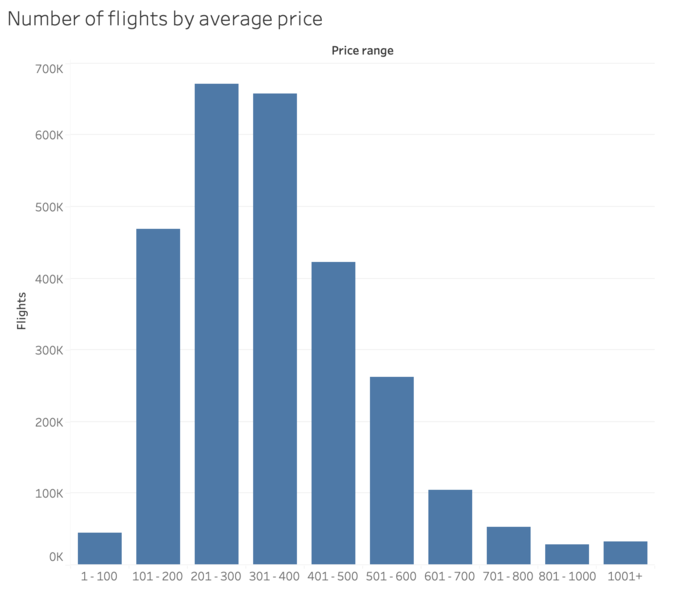

We now compute a custom 'metric': the price per distance ratio, which indicates the cheapest flights that take us as far as possible. 

To obtain the result, we define an RDD with each distinct tuple (flightID, travelDistance), and we join it with the rddAveragePricePerFlight previously defined. 

Finally, we compute the ratio by using a simple map function.

In [ ]:
val rddPricePerDistancePerFlight = rddSearches.
    map(x => (x.flightID, x.travelDistance)).
    distinct().
    join(rddAveragePricePerFlight).
    map({case(x,y) => (x, (y._2/y._1)*10000)})

We define a new RDD that maps each flight to the corresponding departure week, using the function computeWeek() defined previously.

In [ ]:
val rddDistinctFlightsWithPeriod = rddSearches.
    map(x => (x.flightID, computeWeek(x.flightDate))).
    distinct()

The next step is to join the 2 RDDs defined before to have an RDD containing: the flightID, the metric, and the corresponding week. \
Afterward, we perform a map to change the key to the week of the flight. In this way, we can apply a reduceByKey function that keeps only the cheapest flight for each week.

In [ ]:
val rddCheapestFlightsPerWeek = rddPricePerDistancePerFlight.
    join(rddDistinctFlightsWithPeriod).
    map({case(x,y) => (y._2, (y._1, x))}).
    reduceByKey({case(x,y) => {x._2 <= y._2 match {
                              case true => x
                              case false => y}}})

To perform an analysis on the airports, we map each distinct flight to its starting airport, and we join this RDD with the rddPricePerDistancePerFlight defined before.

In [ ]:
val rddPricePerDistancePerFlightWithAirport = rddSearches.
    map(x => (x.flightID, x.startingAirport)).
    distinct().
    join(rddPricePerDistancePerFlight)

We define a new RDD where we remove the flightID, and we aggregate by airport by computing the average price of the flight departing from that airport. \
Then, we sort by the lowest average price,and we save the result in S3.

In [ ]:
val t0 = System.nanoTime()

val rddCheapestAirports = rddPricePerDistancePerFlightWithAirport.
    map({case(x,y) => (y._1, y._2)}).
    aggregateByKey((0.0,0.0))((x,y)=>(x._1+y, x._2 + 1) , (a,b)=>(a._1 + b._1, a._2 + b._2)).
    map({case(k,v) => (v._1/v._2, k)}).
    sortByKey().
    coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9) + " secs")

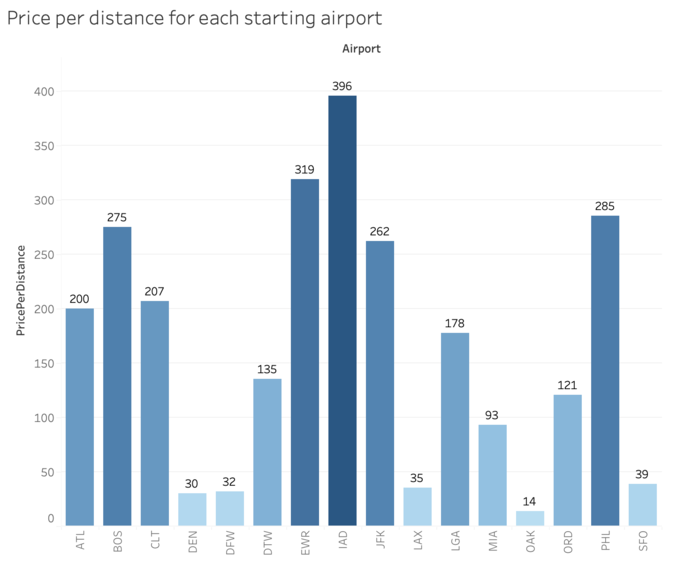

The query takes 283 seconds to execute. \
Now, we try to reduce the execution time.

#### Optimization

We performed the distinct() operation few times, so we define a new RDD that contains the distinct flights, and we utilize it to make the next steps. \
The next RDDs are the same as above, and we simply redefine them to use the cached RDD.

In [ ]:
val rddDistinctFlights = rddSearches.
    map(x => (x.flightID, x.flightDate, x.travelDistance, x.startingAirport)).
    distinct().
    coalesce(500).
    persist(StorageLevel.MEMORY_AND_DISK)

We compute the price per distance ratio for each flight in one step of aggregation. \
By doing so we avoid a join between two rdds which is an expensive operation.

In [ ]:
val z = (0, (0.0, 0.0))

val rddAveragePricePerFlight = rddSearches.
    map(x => (x.flightID, (x.baseFare, x.travelDistance))).
    coalesce(500).
    aggregateByKey(z)(
        (acc, v) => {
            val count = acc._1 + 1
            val fareSum = acc._2._1 + v._1
            val distance = v._2
            (count, (fareSum, distance))
        }, 
        (x, y) => {
            val count = x._1 + y._1
            val fareSum = x._2._1 + y._2._1
            val distance = x._2._2
            (count, (fareSum, distance))
        }).
    map({case(k,(count,(fareSum,distance))) => (k, ((fareSum/count)/distance*10000))})

In [ ]:
val rddDistinctFlightsWithPeriod = rddDistinctFlights.
    map(x => (x._1, computeWeek(x._2)))

In [ ]:
val rddCheapestFlightsPerWeek = rddAveragePricePerFlight.
    join(rddDistinctFlightsWithPeriod).
    map({case(x,y) => (y._2, (y._1, x))}). // (week, (price,id))
    reduceByKey({case(x,y) => {x._2 <= y._2 match {
                              case true => x
                              case false => y}}})

In [ ]:
val rddPricePerDistancePerFlightWithAirport = rddDistinctFlights.
    map(x => (x._1, x._4)).
    join(rddAveragePricePerFlight)

In [ ]:
val t0 = System.nanoTime()

val rddCheapestAirports = rddPricePerDistancePerFlightWithAirport.
    map({case(k,v) => (v._1, v._2)}).
    aggregateByKey((0.0,0.0))((x,y)=>(x._1+y, x._2 + 1) , (a,b)=>(a._1 + b._1, a._2 + b._2)).
    map({case(k,v) => (k, (v._1/v._2).toInt)}).
    sortByKey().
    coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9) + " secs")

We tried different approaches to the optimization, mainly varying the number of partitions and the partitioner. \
To keep the notebook clean, we did not keep all the tests made but only a table with the results. \
In conclusion, the best number of partitions to choose is 30 using the method repartition that forces a shuffle.

| Function | Partitions | Time in seconds
| ----- | ----- | ----- | 
| Not optimized | 927 | 283
| Optimized | 927 | 259
| coalesce | 30 | 224
| coalesce | 100 | 216
| coalesce | 200 | 229
| **repartition** | **30** | **212**
| repartition | 100 | 216
| repartition | 300 | 229